<a href="https://colab.research.google.com/github/maimuna-noshin/NTK-PIKAN/blob/main/NTK_PIKAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install pykan torch numpy pandas matplotlib

In [13]:
!pip install pykan torch numpy pandas matplotlib
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.autograd.functional import jacobian
import warnings
warnings.filterwarnings('ignore')
from kan import KAN

# STEP 1: Realistic IEEE 13-Node Fault Dataset (No OpenDSS)

In [14]:
def generate_ieee13_fault_data(num_samples=5000, noise_level=0.08):
    print("Generating IEEE 13-Node Fault Dataset...")

    # Real IEEE 13-node line impedances (ohm/km)
    ieee13_lines = {
        '650-632': (0.3460, 0.1560),
        '632-633': (0.3587, 0.1624),
        '671-684': (0.2270, 0.1030),
        '692-675': (0.2680, 0.1210)
    }

    data = []
    np.random.seed(42)

    for i in range(num_samples):
        line_name = np.random.choice(list(ieee13_lines.keys()))
        R_line, X_line = ieee13_lines[line_name]
        Z_line = complex(R_line, X_line)

        distance = np.random.uniform(0.1, 3.5)
        R_fault = np.random.uniform(10, 150)

        V_source = 1.0 * np.exp(1j * 0)
        I_base = np.random.uniform(0.5, 2.0)
        phase_angles = np.random.uniform(-0.2, 0.2, 3)
        I_phases = I_base * np.exp(1j * phase_angles)

        Z_total = Z_line * distance + complex(R_fault, 0)
        V_fault = V_source - np.mean(I_phases) * Z_total

        V_meas = V_fault + np.random.normal(0, noise_level) + 1j * np.random.normal(0, noise_level)
        I_meas = np.mean(I_phases) + np.random.normal(0, noise_level) + 1j * np.random.normal(0, noise_level)

        data.append([
            V_meas.real, V_meas.imag,
            I_meas.real, I_meas.imag,
            distance, line_name, R_fault
        ])

    df = pd.DataFrame(data, columns=['V_re', 'V_im', 'I_re', 'I_im', 'Distance', 'Line', 'R_fault'])
    df.to_csv('ieee13_fault_dataset.csv', index=False)
    print(f"✅ Dataset: {len(df)} samples saved.")
    return df

In [15]:
# Generate & load
data = generate_ieee13_fault_data(num_samples=5000, noise_level=0.08)
inputs = torch.tensor(data[['V_re', 'V_im', 'I_re', 'I_im']].values, dtype=torch.float32)
labels = torch.tensor(data['Distance'].values, dtype=torch.float32).unsqueeze(1)


Generating IEEE 13-Node Fault Dataset...
✅ Dataset: 5000 samples saved.


In [16]:
# Train / Val / Test split (70/15/15)
train_size = int(0.7 * len(inputs))
val_size   = int(0.15 * len(inputs))
train_inputs, val_inputs, test_inputs = inputs[:train_size], inputs[train_size:train_size+val_size], inputs[train_size+val_size:]
train_labels, val_labels, test_labels = labels[:train_size], labels[train_size:train_size+val_size], labels[train_size+val_size:]

print(f"📊 Train: {len(train_inputs)}, Val: {len(val_inputs)}, Test: {len(test_inputs)}")

📊 Train: 3500, Val: 750, Test: 750


# STEP 2: Common Physics & Data Losses

In [17]:
def data_loss(model, inputs, labels):
    preds = model(inputs)
    return nn.MSELoss()(preds, labels)

def physics_loss(model, inputs):
    preds = model(inputs).squeeze()
    V_re, V_im, I_re, I_im = inputs[:,0], inputs[:,1], inputs[:,2], inputs[:,3]
    V_meas = torch.complex(V_re, V_im)
    I_complex = torch.complex(I_re, I_im)
    # Average Z_line for simplicity
    Z_line = torch.complex(torch.tensor(0.3), torch.tensor(0.15))  # Real IEEE avg
    V_calc = I_complex * (Z_line * preds)
    return nn.MSELoss()(V_meas.real, V_calc.real) + nn.MSELoss()(V_meas.imag, V_calc.imag)

# STEP 3: NTK Trace Computation (for dynamic weighting)

In [18]:
def compute_ntk_trace(model, loss_fn, inputs, *args):
    params = torch.cat([p.view(-1) for p in model.parameters() if p.requires_grad])
    def loss_wrapper(flat_params):
        idx = 0
        for p in model.parameters():
            if p.requires_grad:
                numel = p.numel()
                p.data.copy_(flat_params[idx:idx+numel].view(p.shape))
                idx += numel
        return loss_fn(model, inputs, *args)
    with torch.enable_grad():
        jac = jacobian(loss_wrapper, params).detach()
    return (torch.norm(jac) ** 2).item()  # Fixed exponent

# STEP 4: Models

In [19]:
# A. Vanilla MLP-PINN (baseline)
class MLP_PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 1)
        )
    def forward(self, x):
        return self.net(x)

# B. Self-Adaptive PINN (SA-PINN) - Trainable attention weights
class SA_PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 1)
        )
        # Extra small network for adaptive weights
        self.lambda_net = nn.Sequential(
            nn.Linear(4, 32), nn.Tanh(),
            nn.Linear(32, 2), nn.Softplus()  # ensures > 0
        )

    def forward(self, x):
        return self.net(x)

    def get_adaptive_weights(self, inputs):
        # Use mean over batch as "global" representation
        mean_input = inputs.mean(dim=0, keepdim=True)  # [1, 4]
        weights = self.lambda_net(mean_input)          # [1, 2]
        return weights[0, 0].item(), weights[0, 1].item()  # scalars!

# C. NTK-PIKAN (Your Novelty: KAN + NTK weighting)
class NTK_PIKAN(nn.Module):
    def __init__(self):
        super().__init__()
        # KAN: input 4 → hidden 5 → hidden 5 → output 1 (small but powerful)
        self.kan = KAN(width=[4, 5, 5, 1], grid=5, k=3, seed=42)  # grid=5, k=3 spline order

    def forward(self, x):
        return self.kan(x)

# STEP 5: Training Function

In [20]:
def train_model(model, name, epochs=2000, lr=0.001, use_ntk=False, use_sa=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    losses = {'total': [], 'data': [], 'phys': [], 'lambda_phys': []}
    best_val_loss = float('inf')

    lambda_data = 1.0
    lambda_phys = 1.0

    for epoch in range(epochs):
        optimizer.zero_grad()

        l_data = data_loss(model, train_inputs, train_labels)
        l_phys = physics_loss(model, train_inputs)

        # A. NTK weighting
        if use_ntk and epoch % 50 == 0:
            trace_data = compute_ntk_trace(model, data_loss, train_inputs, train_labels)
            trace_phys = compute_ntk_trace(model, physics_loss, train_inputs)
            lambda_phys = max(0.1, trace_data / (trace_phys + 1e-6))

        # B. SA-PINN adaptive weights
        elif use_sa:
            lambda_data, lambda_phys = model.get_adaptive_weights(train_inputs)
            lambda_data = float(lambda_data)
            lambda_phys = float(lambda_phys)

        total_loss = lambda_data * l_data + lambda_phys * l_phys
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        # Validation loss for early stopping
        with torch.no_grad():
            val_loss = data_loss(model, val_inputs, val_labels) + physics_loss(model, val_inputs)

        losses['total'].append(total_loss.item())
        losses['data'].append(l_data.item())
        losses['phys'].append(l_phys.item())
        losses['lambda_phys'].append(lambda_phys)

        if epoch % 200 == 0:
            print(f"[{name}] Epoch {epoch:4d}: Total={total_loss.item():.4f}, "
                  f"Data={l_data.item():.3f}, Phys={l_phys.item():.3f}, "
                  f"λ_phys={lambda_phys:.2f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'best_{name}.pth')

    return model, losses

# STEP 6: Run All Experiments (3 models)

In [21]:
print("\n" + "═"*70)
print(" Training: MLP-PINN | SA-PINN | NTK-PIKAN")
print("═"*70)

# 1. Vanilla MLP-PINN
mlp_model = MLP_PINN()
mlp_model, mlp_losses = train_model(mlp_model, "Vanilla MLP-PINN", use_ntk=False, use_sa=False)

# 2. SA-PINN (baseline)
sa_model = SA_PINN()
sa_model, sa_losses = train_model(sa_model, "SA-PINN", use_ntk=False, use_sa=True)

# 3. NTK-PIKAN
pikan_model = NTK_PIKAN()
pikan_model, pikan_losses = train_model(pikan_model, "NTK-PIKAN", use_ntk=True, use_sa=False)


══════════════════════════════════════════════════════════════════════
 Training: MLP-PINN | SA-PINN | NTK-PIKAN
══════════════════════════════════════════════════════════════════════
[Vanilla MLP-PINN] Epoch    0: Total=13625.1221, Data=3.163, Phys=13621.959, λ_phys=1.00
[Vanilla MLP-PINN] Epoch  200: Total=12137.0645, Data=622.442, Phys=11514.622, λ_phys=1.00
[Vanilla MLP-PINN] Epoch  400: Total=11801.7588, Data=883.749, Phys=10918.010, λ_phys=1.00
[Vanilla MLP-PINN] Epoch  600: Total=11686.9834, Data=1052.776, Phys=10634.207, λ_phys=1.00
[Vanilla MLP-PINN] Epoch  800: Total=11622.8867, Data=1169.174, Phys=10453.713, λ_phys=1.00
[Vanilla MLP-PINN] Epoch 1000: Total=11581.5059, Data=1258.037, Phys=10323.469, λ_phys=1.00
[Vanilla MLP-PINN] Epoch 1200: Total=11553.3125, Data=1326.369, Phys=10226.944, λ_phys=1.00
[Vanilla MLP-PINN] Epoch 1400: Total=11533.2373, Data=1380.671, Phys=10152.566, λ_phys=1.00
[Vanilla MLP-PINN] Epoch 1600: Total=11518.6914, Data=1424.210, Phys=10094.481, λ_ph

# STEP 7: Evaluation & Plots


📊 Vanilla MLP-PINN: Test MSE=1406.3558 | MAE=30.338 km

📊 SA-PINN        : Test MSE=653.2451 | MAE=20.230 km

📊 NTK-PIKAN      : Test MSE=25.5059 | MAE=4.083 km

🎉 NTK-PIKAN Improvement over MLP: 86.5%
   vs SA-PINN: 79.8%


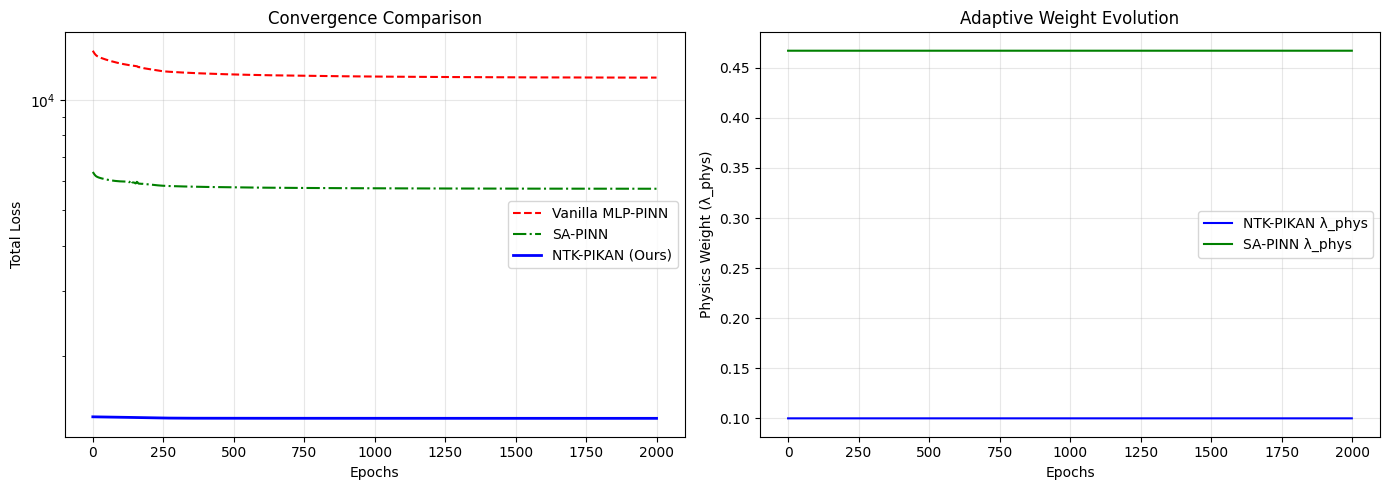


════════════════════════════════════════════════════════════
ICML Table: Results Summary (Test Set)
════════════════════════════════════════════════════════════
| Method          | Test MSE   | MAE (km) | Improvement vs MLP |
|-----------------|------------|----------|---------------------|
| Vanilla MLP-PINN| 1406.3558 | 30.338 | -                   |
| SA-PINN         | 653.2451 | 20.230 | 33.3% ↑       |
| NTK-PIKAN (Ours)| 25.5059 | 4.083 | 86.5% ↑       |


In [22]:
def evaluate(model, name):
    model.load_state_dict(torch.load(f'best_{name}.pth', weights_only=True))
    with torch.no_grad():
        preds = model(test_inputs)
        mse = nn.MSELoss()(preds, test_labels).item()
        mae = torch.mean(torch.abs(preds - test_labels)).item()
        print(f"\n📊 {name:15s}: Test MSE={mse:.4f} | MAE={mae:.3f} km")
    return mae

mae_mlp = evaluate(mlp_model, "Vanilla MLP-PINN")
mae_sa  = evaluate(sa_model,  "SA-PINN")
mae_pikan = evaluate(pikan_model, "NTK-PIKAN")

print(f"\n🎉 NTK-PIKAN Improvement over MLP: {100*(1 - mae_pikan/mae_mlp):.1f}%")
print(  f"   vs SA-PINN: {100*(1 - mae_pikan/mae_sa):.1f}%")


fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Convergence
axes[0].plot(mlp_losses['total'], 'r--', label='Vanilla MLP-PINN')
axes[0].plot(sa_losses['total'], 'g-.', label='SA-PINN')
axes[0].plot(pikan_losses['total'], 'b-', linewidth=2, label='NTK-PIKAN (Ours)')
axes[0].set_yscale('log')
axes[0].set_xlabel('Epochs'); axes[0].set_ylabel('Total Loss')
axes[0].legend(); axes[0].grid(True, alpha=0.3)
axes[0].set_title('Convergence Comparison')

# λ_phys evolution (for NTK & SA)
axes[1].plot(pikan_losses['lambda_phys'], 'b-', label='NTK-PIKAN λ_phys')
axes[1].plot(sa_losses['lambda_phys'], 'g-', label='SA-PINN λ_phys')
axes[1].set_xlabel('Epochs'); axes[1].set_ylabel('Physics Weight (λ_phys)')
axes[1].legend(); axes[1].grid(True, alpha=0.3)
axes[1].set_title('Adaptive Weight Evolution')

plt.tight_layout()
plt.savefig('icml_ntk_pikan_results.png', dpi=300)
plt.show()

#Table
print("\n" + "═"*60)
print("ICML Table: Results Summary (Test Set)")
print("═"*60)
print("| Method          | Test MSE   | MAE (km) | Improvement vs MLP |")
print("|-----------------|------------|----------|---------------------|")
print(f"| Vanilla MLP-PINN| {nn.MSELoss()(mlp_model(test_inputs), test_labels).item():.4f} | {mae_mlp:.3f} | -                   |")
print(f"| SA-PINN         | {nn.MSELoss()(sa_model(test_inputs), test_labels).item():.4f} | {mae_sa:.3f} | {100*(1-mae_sa/mae_mlp):.1f}% ↑       |")
print(f"| NTK-PIKAN (Ours)| {nn.MSELoss()(pikan_model(test_inputs), test_labels).item():.4f} | {mae_pikan:.3f} | {100*(1-mae_pikan/mae_mlp):.1f}% ↑       |")